# Анализ поведения пользователей мобильного приложения

## Описание проекта:
- Необходимо разобраться в поведении пользователей мобильного приложения по доставке продуктов питания.   
- Исследуем воронку продаж,  узнаем как пользователи доходят до покупки.   
- Дизайнеры захотели поменять шрифты в приложении, а  чтобы посмотреть как пользователи реагируют на нововведения запустили A/A/B тест.Исследуем результаты тестирования и выясним какой шрифт лучше.

## Описание данных:
Файл /datasets/hypothesis.csv

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.   
   
Файл /datasets/orders.csv

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.    
    
Файл /datasets/visitors.csv.

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

##  Знакомство с информацией.

Подключим необходимые библиотеки, которые потребуются для выполнения проекта

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import plotly.express as px
import math as mth
import warnings

In [2]:
warnings.filterwarnings("ignore")

Сохраним датасет в переменную data. и воспользуемся разделителем по '\t'

In [3]:
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
except FileNotFoundError:
    data = pd.read_csv('/Users/aleksandrefimcev/Desktop/logs_exp.csv', sep = '\t') 

In [4]:
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


##  Подготовка данных.

###  Приведение столбцов к удобному виду.

In [5]:
data = ( data.rename(columns = {'EventName':'event_name'
                                ,'DeviceIDHash':'user_id','EventTimestamp':'event_time'
                               ,'ExpId':'group'})
       )

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   event_time  244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В датасете 4 колонки с 224126 записей.   
Пропусков в датасете нет.    
Подготовим данные для дальнейшего исследования.      
Изменим тип времени.

In [7]:
data['event_time'] = data['event_time'].apply(dt.datetime.fromtimestamp)

In [8]:
data.head(5)

,event_name,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,248


### Добавление отдельного столбца с датой.

In [9]:
data['date'] = data['event_time'].dt.to_period('D')

In [10]:
data.head(5)

,event_name,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,248,2019-07-25


### Проверка данных на дубликаты

Посчитаем количествло дубликатов в датасете

In [11]:
data.duplicated().sum()

413

В наших данных 413 явных дубликатов.

In [12]:
print(f'{round((data.duplicated().sum()) / len (data) * 100 ,2)}% дубликатов в датасете')

0.17% дубликатов в датасете


Так как 0.17 % не повлияют на исход анализа,  удалим дубликаты

In [13]:
data = data.drop_duplicates()

Убедимся в том,  что дубликаты удалены.

In [14]:
data.duplicated().sum()

0

На этом шаге мы:   
-- изменили названия столбцов на названия удобные для работы  
-- преобразовали столбец event_time из секунд в дату и время   
-- удалили дубликаты    
-- дополнительно создали столбец с датой

## Изучение  и проверка данных

### Количество событий в логе

In [15]:
count_log = data['event_name'].count()
print(f'Всего в логе: {count_log} событий')

Всего в логе: 243713 событий


### Количество пользователей в логе

In [16]:
count_user = data['user_id'].nunique()
print(f'Всего в логе: {count_user} пользователей')

Всего в логе: 7551 пользователей


 ### Среднее количество событий на пользователя

In [17]:
print(f'Среднее количество событий в логе на одного пользователя: {int(count_log/count_user)}')

Среднее количество событий в логе на одного пользователя: 32


Посмотрим как распределяются события по пользователям. Построим гистограмму

In [18]:
event_df = data.pivot_table(index = 'user_id'
                 , values = 'event_name'
                 , aggfunc = {'count'})

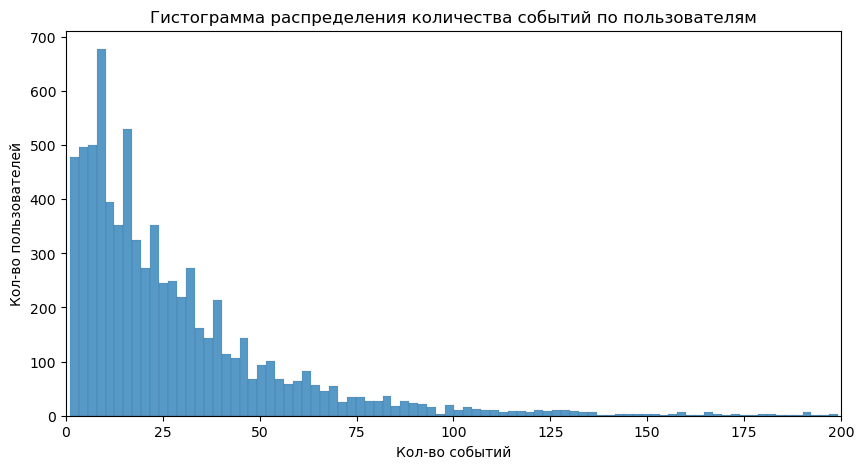

In [19]:
plt.figure(figsize=(10, 5))
fig = sns.histplot(data = event_df, x='count', bins=1000)
fig.set(xlabel='Кол-во событий'
        , ylabel = 'Кол-во пользователей'
        , title = 'Гистограмма распределения количества событий по пользователям'
        , xlim = (0,200)
       );

Посмотрим на значение медианы

In [20]:
data.pivot_table(index = 'user_id'
                 , values = 'event_name'
                 , aggfunc = {'count'}).median()

count    20.0
dtype: float64

Как мы видим распределение на гистограмме скошено вправо. Среднее сдвинуто по отношению к медиане вправо.

Посмотрим  на минимальную и максимульную даты

In [21]:
min_date = data['date'].min()
print(f'Минимальная дата: {min_date}')

Минимальная дата: 2019-07-25


In [22]:
max_date = data['date'].max()
print(f'Максимальная дата: {max_date}')

Максимальная дата: 2019-08-08


Минимальная дата в нашем датасете: 25 июля 2019 года    
Максимальная дата в нашем датасете: 07 августа 2019 года 

Построим гистограмму по дате и времени

''

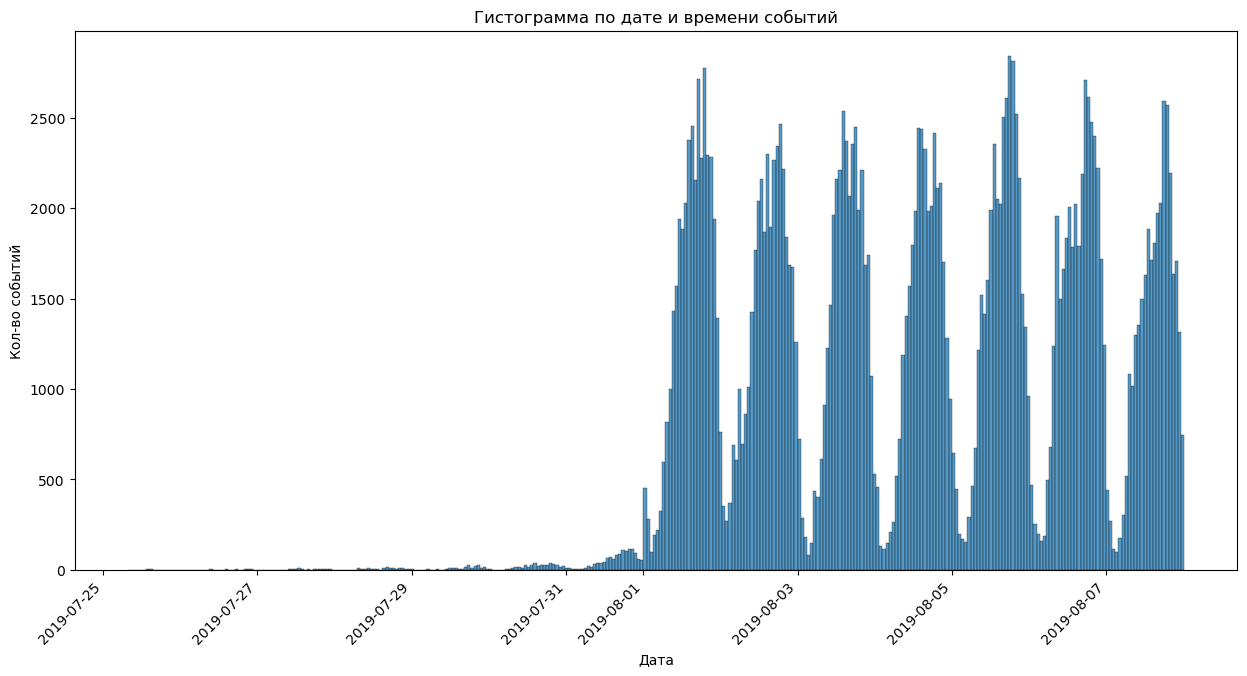

In [23]:
plt.figure(figsize=(15, 7))
fig = sns.histplot(data = data['event_time'],bins = 14*24)
plt.xticks(rotation=45, ha='right')
plt.title('Гистограмма по дате и времени событий')
fig.set(xlabel = 'Дата',ylabel = 'Кол-во событий')
;


Как видно на гистограмме полные данные начинаются с 1 августа 2019 года. Посчитаем процент данных до 1 августа 2019 года.

Отбросим ненужные данные и сохраним в новом датафреме data_new   
Изначальный датафрейм не будем перезаписывать,  тк в дальнейшем возможно он может понадобиться.

In [25]:
data_new = data[data['date'] >=  '2019-08-01']

###  Взглянем много ли событий и пользователей исчезнут, отбросив старые данные

In [83]:
print(f'Отбросив старые данные мы потеряли {round(len(until_aug) / len(data) * 100,2)} % событий')

Отбросив старые данные мы потеряли 0.82 % событий


In [84]:
old_users = data['user_id'].nunique()

In [85]:
new_users = data_new['user_id'].nunique()

In [86]:
print (   f'''Количество пользователей в старыйх данных: {old_users}
Количество пользователей в новых данных: {new_users}
Потеря пользователей составила: {round(100 - (new_users / old_users * 100),2)}%
          ''')
      

Количество пользователей в старыйх данных: 7551
Количество пользователей в новых данных: 7538
Потеря пользователей составила: 0.17%
          


После того как мы отбросили данные, мы потеряли чуть более 1% событий и 0.23% пользователей. Это незначительнное количество данных, можно продолжать исследование.

### Проверим что в наших данных присутствуют пользователи из трёх разных групп

In [31]:
user_group = data_new.pivot_table(index = 'group', values = 'user_id', aggfunc = {'nunique'}).reset_index()

In [32]:
user_group.columns = ['Номер группы','Количество человек']

In [33]:
user_group

,Номер группы,Количество человек
0,246,2484
1,247,2517
2,248,2537


Создадим функцию формата,  которая будет выводить вместе с процентами числовое значение в графиках

In [34]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

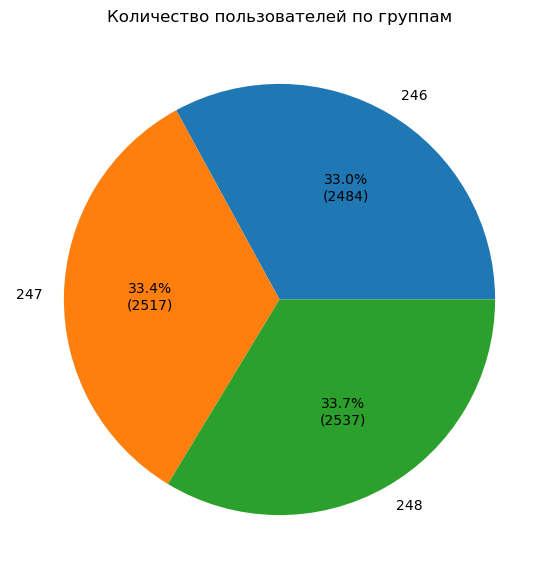

In [35]:
plt.figure(figsize=(10, 7))
plt.pie(data = user_group
        ,x = 'Количество человек'
        , labels = 'Номер группы'
        ,autopct=autopct_format(user_group['Количество человек']))
plt.title('Количество пользователей по группам')
plt.show()

Как мы видим пользователи всех трёх групп присутствуют в данных. Группы разделены примерно поровну.

##  Изучим воронку событий

### Посмотрим  какие события есть в логах и как часто они встречаются

In [36]:
event_logs = (
    data_new.pivot_table(index = 'event_name',
    values = 'user_id', aggfunc = {'count'})
    .sort_values(by = 'count',ascending = False)
    .reset_index()
)

In [37]:
event_logs.columns = ['Название события', 'Количество событий']

In [38]:
event_logs

,Название события,Количество событий
0,MainScreenAppear,117889
1,OffersScreenAppear,46531
2,CartScreenAppear,42343
3,PaymentScreenSuccessful,33951
4,Tutorial,1010


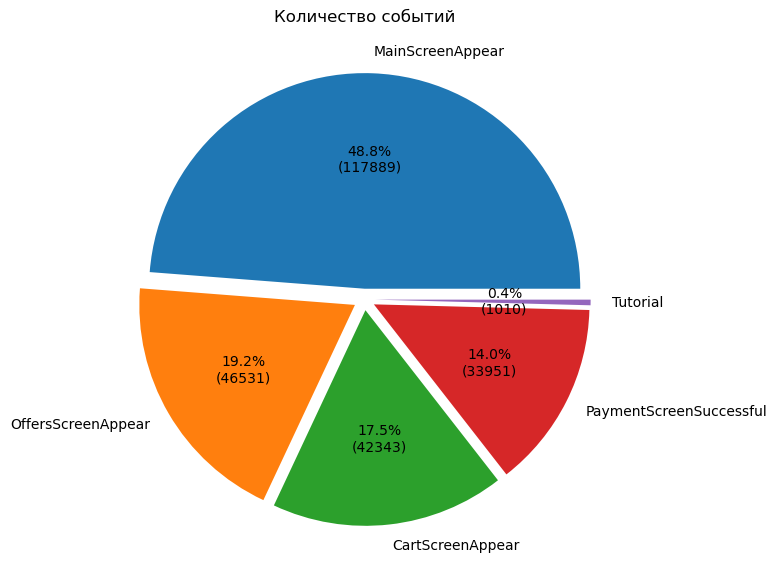

In [39]:
plt.figure(figsize=(10, 7))
explode = [0.05,0.05,0.05,0.05,0.05]
plt.pie(
    data = event_logs
    ,x = 'Количество событий'
    ,labels = 'Название события'
    , autopct=autopct_format(event_logs['Количество событий'])
    , explode = explode
)
colors = sns.color_palette('bright')
plt.title('Количество событий')
plt.show()


Почти половину из всех событий в логах приходится на нахождение в  основном экране приложения 48,7 %.  
Экран предложений насчитывает 19,2 %   
Экран с корзиной насчитывает 17.6 %    
На экран с покупкой приходится  14.1 %   
Менее 1 %  составляют логи с обучением.  Почти никто не пользуется экраном обучения.


### Посчитаем сколько пользователей совершали каждое из этих событий.

In [40]:
event_user = (
    data_new.pivot_table(index = 'event_name',
    values = 'user_id', aggfunc = {'nunique'})
    .sort_values(by = 'nunique',ascending = False)
    .reset_index()
)

In [41]:
event_user.columns = ['Название события', 'Количество пользователей']

In [42]:
event_user

,Название события,Количество пользователей
0,MainScreenAppear,7423
1,OffersScreenAppear,4597
2,CartScreenAppear,3736
3,PaymentScreenSuccessful,3540
4,Tutorial,843


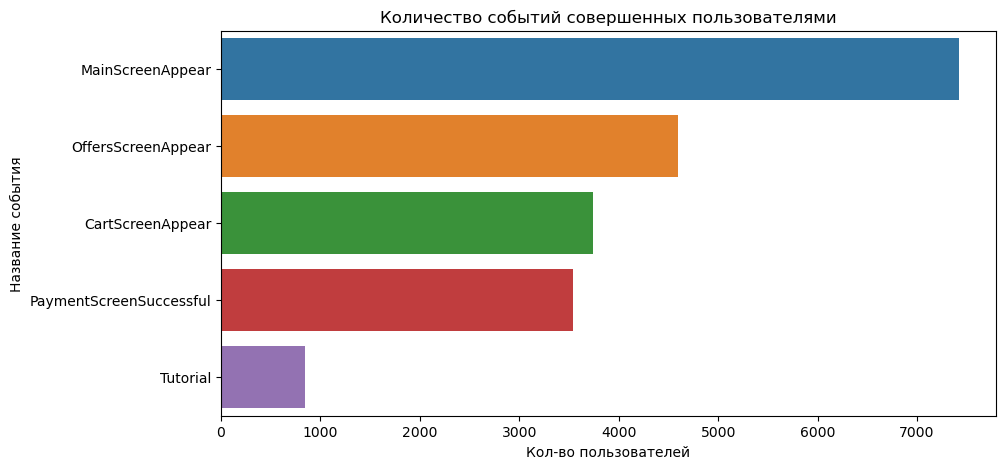

In [90]:
plt.figure(figsize=(10, 5))
fig = sns.barplot (x= 'Количество пользователей', y= 'Название события', data=event_user)
fig.set(xlabel='Кол-во пользователей'
        , ylabel = 'Название события'
        , title = 'Количество событий совершенных пользователями'
       );

Как мы видим  на гланый  экран приложения пришли почти 7419 пользователей из них 4593 человек перешли в раздел с предложениями,  3734 человек дошли до просмотра корзины с покупками, и до раздела оплаты дошло 3539 человек.   
Раздел с обучением открыло 840 клиентов.   
На предыдущем графике было показано что событие 'Просмотр туториала ' в логах происходило 1005 раз,  видимо некоторые клинеты просматривали этот раздел повторно.

### Посчитаем  долю пользователей, которые хоть раз совершали событие.

Созадим переменную в которую добавим клиентов которые дошли до главного экрана

In [44]:
event_user_1 = data_new[data_new['event_name'] == 'MainScreenAppear']['user_id'].nunique()

In [45]:
print(f'Доля пользователей хоть раз совершивших событие: {round(event_user_1 / new_users *100,2)}%')

Доля пользователей хоть раз совершивших событие: 98.47%


Как видно что в наших данных есть 1.5 процента пользователей случайно попавших в нашу выборку   
Посмотрим на примере пользователя с ID: 9217594193087726423

In [46]:
data[data['user_id']== 9217594193087726423]

,event_name,user_id,event_time,group,date
48912,PaymentScreenSuccessful,9217594193087726423,2019-08-02 12:00:57,246,2019-08-02
48918,CartScreenAppear,9217594193087726423,2019-08-02 12:00:58,246,2019-08-02
48930,PaymentScreenSuccessful,9217594193087726423,2019-08-02 12:01:06,246,2019-08-02
48931,CartScreenAppear,9217594193087726423,2019-08-02 12:01:06,246,2019-08-02
48933,OffersScreenAppear,9217594193087726423,2019-08-02 12:01:08,246,2019-08-02
48969,OffersScreenAppear,9217594193087726423,2019-08-02 12:01:38,246,2019-08-02
80840,PaymentScreenSuccessful,9217594193087726423,2019-08-03 11:09:24,246,2019-08-03
80843,OffersScreenAppear,9217594193087726423,2019-08-03 11:09:25,246,2019-08-03
80844,CartScreenAppear,9217594193087726423,2019-08-03 11:09:25,246,2019-08-03


Из лога пользователя видно,  что у все действия происходили без выхода на главный экран, такие пользователи могут некорректно повлиять на исследование,  но поскольку таких пользователей 1.5 % они не помешают исследованию.

### Посчитаем  долю пользователей, которые хоть раз совершали каждое из событий.

In [47]:
event_user['Все пользователи'] = data_new['user_id'].nunique()

In [48]:
event_user['Процент пользователей'] = (round(event_user['Количество пользователей'] 
                                             / event_user['Все пользователи'] 
                                    * 100,2)
                             )

In [93]:
event_user

,Название события,Количество пользователей,Все пользователи,Процент пользователей
0,MainScreenAppear,7423,7538,98.47
1,OffersScreenAppear,4597,7538,60.98
2,CartScreenAppear,3736,7538,49.56
3,PaymentScreenSuccessful,3540,7538,46.96
4,Tutorial,843,7538,11.18


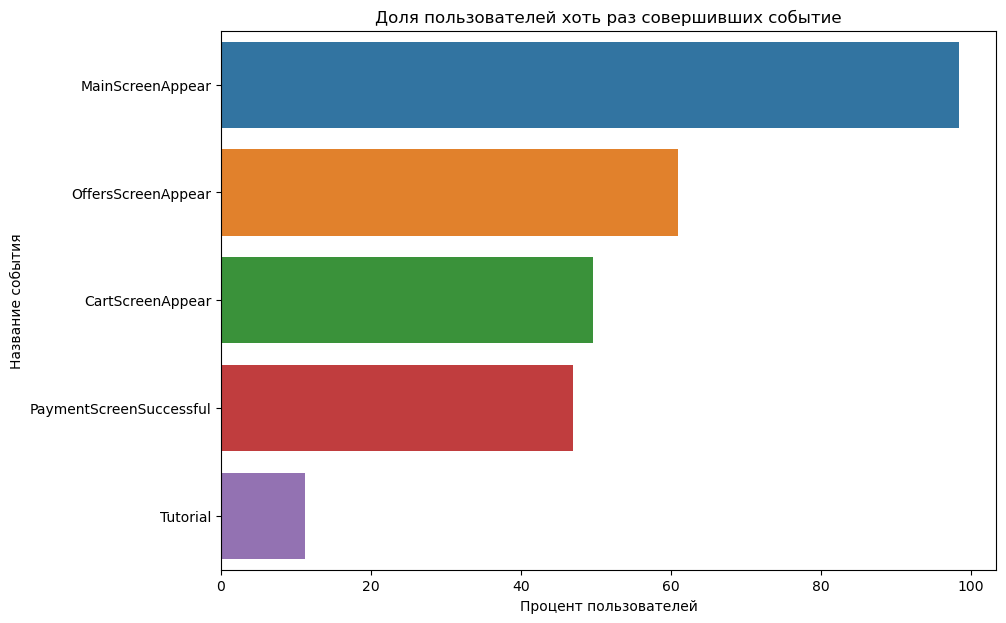

In [94]:
plt.figure(figsize=(10, 7))
fig = sns.barplot (x= 'Процент пользователей', y= 'Название события', data=event_user)
fig.set(xlabel='Процент пользователей'
        , ylabel = 'Название события'
        , title = 'Доля пользователей хоть раз совершивших событие'
       );

Как мы видим чуть более 98,5 % пользователей перешли на главный экран.  
61% пользователей перешли на экран предложений.   
49,5 % пользователей перешли в корзину.    
47% пользователей дошли до страницы с оплатой
11 %. пользователей воспользоватлись туториалом.


### Предположим, в каком порядке происходят события

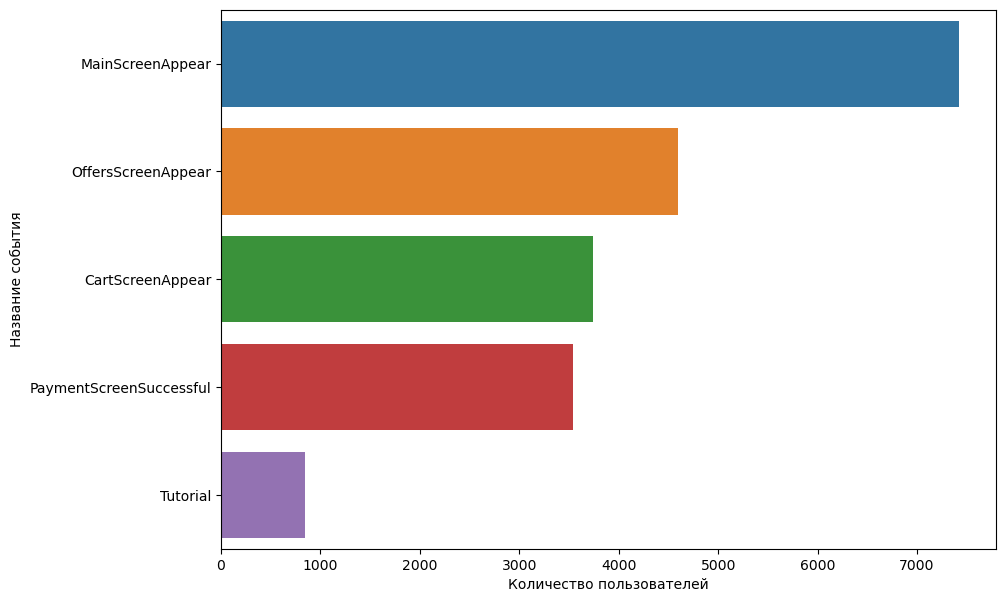

In [51]:
plt.figure(figsize=(10, 7))
sns.barplot (x= 'Количество пользователей', y= 'Название события', data=event_user);

Исходя из графика можно сделать вывод что пользователь попадает на начальный экран, далее переходит на экран с предложениями,  после выбора необходимых товаров переходит в корзину, далее идет страница оплаты. Туториал покупатель может посмотреть в любой момент. 

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг

In [52]:
next_step = event_user[['Название события','Количество пользователей']]

In [53]:
next_step['previous'] = next_step['Количество пользователей'].shift(1,fill_value=0)

Проверим как отображаются даные

In [54]:
next_step

,Название события,Количество пользователей,previous
0,MainScreenAppear,7423,0
1,OffersScreenAppear,4597,7423
2,CartScreenAppear,3736,4597
3,PaymentScreenSuccessful,3540,3736
4,Tutorial,843,3540


In [55]:
def user_next_step(df):
    for index in df['Название события']:
        df['percent_next_step'] = round(df['Количество пользователей'] / df['previous'] * 100)
        
    return df[1:-1] # Исключим первую строку с 0 и последнюю строку с туториалом
        

In [56]:
user_next_step(next_step)

,Название события,Количество пользователей,previous,percent_next_step
1,OffersScreenAppear,4597,7423,62.0
2,CartScreenAppear,3736,4597,81.0
3,PaymentScreenSuccessful,3540,3736,95.0


От начального экрана до экрана с предложениями доходит: 62% пользователей.
С экрана  предложений до корзины с покупками  доходит: 81% пользователей.
Завершают покупку: 95% пользователей.

Визуализируем воронку пользователей

In [100]:
voronka = dict(
    number = [7420,4593,3734,3539],
    stage = ['Mainscreen','Offers','Cart','Payment']
)
fig = px.funnel(voronka, x = 'number', y = 'stage',title = 'Воронка пользователей')
fig.show()

Как мы видим больше всего пользователей теряется на этапе перехода на страницу с предложениями,  хдоходит чуть более 60 %  пользователей. Далее пользователи охотно добавляют товары в корзину и приобретают, 80 % товаров добавленных в корзину покупают.

### Посмотрим какая доля пользователей доходит от первого события до оплаты

In [58]:
next_step

,Название события,Количество пользователей,previous,percent_next_step
0,MainScreenAppear,7423,0,inf
1,OffersScreenAppear,4597,7423,62.0
2,CartScreenAppear,3736,4597,81.0
3,PaymentScreenSuccessful,3540,3736,95.0
4,Tutorial,843,3540,24.0


In [59]:
payment= next_step[next_step['Название события']=='PaymentScreenSuccessful']['Количество пользователей'].sum()

In [60]:
main_screen = next_step[next_step['Название события']=='MainScreenAppear']['Количество пользователей'].sum()

In [61]:
print(f'От первого события до оплаты доходит: {round(payment/main_screen * 100)} % пользователей.')

От первого события до оплаты доходит: 48 % пользователей.


In [101]:
first_last = dict(
    znach = [main_screen,payment],
    label = ['Mainscreen','Payment']
)
fig = px.funnel(first_last, x = 'znach', y = 'label',title = 'Воронка от первого события до оплаты')
fig.show()

## Изучим результаты эксперимента

### Посмотрим сколько пользователей в каждой экспериментальной группе.

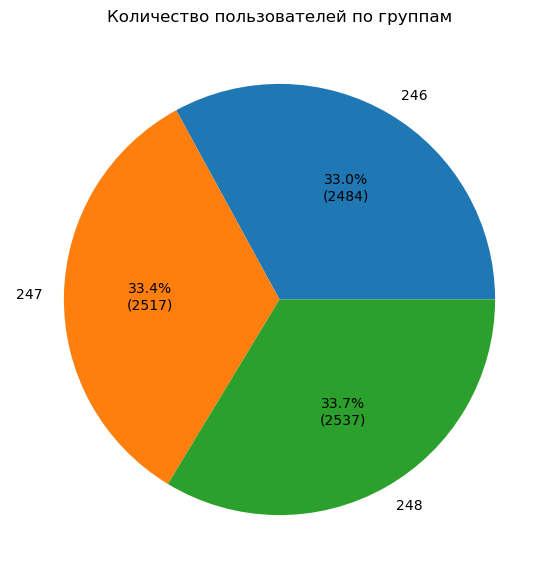

In [63]:
plt.figure(figsize=(10, 7))
plt.pie(data = user_group
        ,x = 'Количество человек'
        , labels = 'Номер группы'
        ,autopct=autopct_format(user_group['Количество человек']))
plt.title('Количество пользователей по группам')
plt.show()

Как мы видим количество пользоватей в группах распределены равномерно   
2484 тысяч в эксперементальной группе А(246)
2513 тысяч в эксперементальной группе А(247)
2537 тысячи в эксперементальной группе B(248)

Посмотрим есть ли в наших группах клиенты, которые одновременно состоят в нескольких группах

In [65]:
double = data_new.groupby('user_id').agg({'group':'nunique'}).reset_index()

In [66]:
double.head(5)

,user_id,group
0,6888746892508752,1
1,6909561520679493,1
2,6922444491712477,1
3,7435777799948366,1
4,7702139951469979,1


In [67]:
double['group'].unique()

array([1])

Данные по группам корректны,  задвоений пользователей нет, двигаемся дальше.

### Проверим, находят ли статистические критерии разницу между выборками 246 и 247

В нашем эксперименте мы будем использовать Z тест, тк будем сравнивать доли пользователей. Необходимо определиться с выбором уровня статистической значимости. Поскольку мы будем использовать множество сравнений, воспользуемся поправкой Бонферрони, разделим уровень статистической значимости 0.05 / 16. Alpha = 0.003

Создадим функцию которую в дальнейшем будем использовать

In [68]:
def z_test(group_1S,group_2S,group_1t,group_2t):
    alpha = 0.003 # критический уровень статистической значимости

    successes = np.array([group_1S,group_2S])
    trials = np.array([group_1t,group_2t])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между группами есть разница'
        )

Сгруппируем 3 датасета по группам

In [69]:
group_246 = data_new.query('group == 246')

In [70]:
group_247 = data_new.query('group == 247')

In [71]:
group_248 = data_new.query('group == 248')

Создадим еще один датасет, общий для 2ух тестовых групп.

In [72]:
group_246_247 = data_new[data_new['group'] != 248]

Создадим переменные,  которые пригодятся при дальнейшем вызове функции

In [73]:
groupname246 = '246'

In [74]:
groupname247 = '247'

In [75]:
groupname248 = '248'

In [76]:
groupnameUnion = '247 и 248'

Создадим функцию которая покажет количество пользователей совершивших действие, а так же долю от общего числа пользователей в группе. Так же функция будет выводить результат Z тестирования долей в группах:

In [77]:
def test_func(data,group1,group2,group1_name,group2_name):
    for index in data['event_name'].unique():
        if index != 'Tutorial':
            print(index)
            user_first_group = group1['user_id'].nunique() 
            user_second_group = group2['user_id'].nunique() 
            print(f'В группе{group1_name} совершили событие:{group1[group1["event_name"] == index]["user_id"].nunique()} пользователей')
            print(f'В группе{group2_name} совершили событие:{group2[group2["event_name"] == index]["user_id"].nunique()} пользователей')
            print(f'В группе {group1_name} процент пользоватеоей:{(group1[group1["event_name"] == index]["user_id"].nunique())/user_first_group *100}')
            print(f'В группе {group2_name} процент пользоватеоей:{(group2[group2["event_name"] == index]["user_id"].nunique())/user_second_group *100}')
            print('')
            z_test(group1[group1['event_name'] == index]['user_id'].nunique()
               ,group2[group2['event_name'] == index]['user_id'].nunique()
               ,group1['user_id'].nunique()
               ,group2['user_id'].nunique()
                  )
            print('')

Сформулируем гипотезы:   
H0: Между группами 246 и 247 есть статистически значимые различия.  
H1: Между группами 246 и 247 нет статистически значимых различий

Вызовем функцию

In [78]:
test_func(data_new,group_246,group_247,groupname246,groupname247)

MainScreenAppear
В группе246 совершили событие:2450 пользователей
В группе247 совершили событие:2479 пользователей
В группе 246 процент пользоватеоей:98.63123993558777
В группе 247 процент пользоватеоей:98.49026618990862

p-значение:  0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между группами есть разница

OffersScreenAppear
В группе246 совершили событие:1542 пользователей
В группе247 совершили событие:1524 пользователей
В группе 246 процент пользоватеоей:62.07729468599034
В группе 247 процент пользоватеоей:60.54827175208581

p-значение:  0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между группами есть разница

PaymentScreenSuccessful
В группе246 совершили событие:1200 пользователей
В группе247 совершили событие:1158 пользователей
В группе 246 процент пользоватеоей:48.309178743961354
В группе 247 процент пользоватеоей:46.00715137067938

p-значение:  0.10298394982948822
Не получилось отвергнуть нулев

Как мы видим между двумя контрольными группами группа 246 незначительно опережает группу 247,но  по всем событиям p - value значительно выше критического уровня статистической значимости. Между выборками нет статистически значимого различия

### Проверим, находят ли статистические критерии разницу между выборками 246 и 248

Сформулируем гипотезы:   
H0: Между группами 246 и 248 есть статистически значимые различия.  
H1: Между группами 246 и 248 нет статистически значимых различий

In [79]:
test_func(data_new,group_246,group_248,groupname246,groupname248)

MainScreenAppear
В группе246 совершили событие:2450 пользователей
В группе248 совершили событие:2494 пользователей
В группе 246 процент пользоватеоей:98.63123993558777
В группе 248 процент пользоватеоей:98.30508474576271

p-значение:  0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между группами есть разница

OffersScreenAppear
В группе246 совершили событие:1542 пользователей
В группе248 совершили событие:1531 пользователей
В группе 246 процент пользоватеоей:62.07729468599034
В группе 248 процент пользоватеоей:60.34686637761135

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между группами есть разница

PaymentScreenSuccessful
В группе246 совершили событие:1200 пользователей
В группе248 совершили событие:1182 пользователей
В группе 246 процент пользоватеоей:48.309178743961354
В группе 248 процент пользоватеоей:46.59046117461569

p-значение:  0.22269358994682742
Не получилось отвергнуть нуле

Как мы видим между контрольная группа 246 незначительно опережает группу  248 по всем событиям.P - value  выше критического уровня статистической значимости.
Между выборками нет статистически значимого различия, изменение шрифтов не отразилось на пользователях.

### Проверим, находят ли статистические критерии разницу между выборками 247 и 248

Сформулируем гипотезы:   
H0: Между группами 247 и 248 есть статистически значимые различия.  
H1: Между группами 247 и 248 нет статистически значимых различий

In [80]:
test_func(data_new,group_247,group_248,groupname247,groupname248)

MainScreenAppear
В группе247 совершили событие:2479 пользователей
В группе248 совершили событие:2494 пользователей
В группе 247 процент пользоватеоей:98.49026618990862
В группе 248 процент пользоватеоей:98.30508474576271

p-значение:  0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между группами есть разница

OffersScreenAppear
В группе247 совершили событие:1524 пользователей
В группе248 совершили событие:1531 пользователей
В группе 247 процент пользоватеоей:60.54827175208581
В группе 248 процент пользоватеоей:60.34686637761135

p-значение:  0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между группами есть разница

PaymentScreenSuccessful
В группе247 совершили событие:1158 пользователей
В группе248 совершили событие:1182 пользователей
В группе 247 процент пользоватеоей:46.00715137067938
В группе 248 процент пользоватеоей:46.59046117461569

p-значение:  0.6775413642906454
Не получилось отвергнуть нулевую 

Как мы видим между двумя контрольными группами по всем событиям p - value значительно выше критического уровня статистической значимости. Между выборками нет статистически значимого различия, изменение шрифтов не отразилось на пользователях.

### Проверим, находят ли статистические критерии разницу между выборками 246+247  и 248

Объединим группы 246 и 247 и сравним с группой 248

Сформулируем гипотезы:   
H0: Между обьедененной группой(246+247) и группой 248 есть статистически значимые различия.  
H1: Между обьедененной группой(246+247)и группой 248 нет статистически значимых различий

In [81]:
test_func(data_new,group_246_247,group_248,groupnameUnion,groupname248)

MainScreenAppear
В группе247 и 248 совершили событие:4929 пользователей
В группе248 совершили событие:2494 пользователей
В группе 247 и 248 процент пользоватеоей:98.56028794241152
В группе 248 процент пользоватеоей:98.30508474576271

p-значение:  0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между группами есть разница

OffersScreenAppear
В группе247 и 248 совершили событие:3066 пользователей
В группе248 совершили событие:1531 пользователей
В группе 247 и 248 процент пользоватеоей:61.307738452309536
В группе 248 процент пользоватеоей:60.34686637761135

p-значение:  0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между группами есть разница

PaymentScreenSuccessful
В группе247 и 248 совершили событие:2358 пользователей
В группе248 совершили событие:1182 пользователей
В группе 247 и 248 процент пользоватеоей:47.150569886022794
В группе 248 процент пользоватеоей:46.59046117461569

p-значение:  0.645205767309

Как мы видим между двумя контрольными группами по всем событиям p - value значительно выше критического уровня статистической значимости. Между выборками нет статистически значимого различия, изменение шрифтов не отразилось на пользователях.

# Вывод:

- На входе мы получили датасет с логами событий пользователей.
- На первом  шаге мы предобработали датасет для удобной работы с ним.

- Далее мы исключили ненужные данные,  а именно  чуть более 1% событий и 0.23% пользователей до 1 августа 2019 года.

Изучив логи мы увидели что:  
- На гланый экран приложения пришли почти 7419 (98,5 % от всех пользователей) пользователей из них 4593 (61% от всех пользователей) человек перешли в раздел с предложениями, 3734 (49,5 % от всех пользователей) человек дошли до просмотра корзины с покупками, и до раздела оплаты дошло 3539 (47 % от всех пользователей)человек.

- От первого события до оплаты доходит: 48 % пользователей. Больше всего пользователей (39%) отваливается на этапе перехода из главного меню в меню с предложениями. 


- При помощи  Z теста, мы сделали множественные сравнения контрольных и эксперементальной группы и выяснили что изменение шрифтов не отразилось и никак не повлияло на пользовательскую активность.


